## Portfolio & Risk Management Notebook ##

The goal of this notebook is to evaluate a hypothetical portfolio of 5 securities between the dates 01/01/2015 - 12/31/2019.

The portfolio consists of equities and ETFs (MSFT, LQD, NVDA, LULU, SLV)

**Method:** 
- first, the price and return series for each security will be visualized 
- Second, optimal portfolio weights via the Markowitz Efficient Frontier
- Third, portfolio risk metrics (VaR, HVaR, and ES) will be analyzed
- Fourth, Monte Carlo simulation will be used to create a synthetic time series with similar mean and variance properties to the observed return series, in order to further evaluate tail risks


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import math
from numpy import linalg as LA
from scipy.optimize import minimize

In [2]:
env = pd.read_pickle('portfolio2015-2019')
env['ticker'].unique()

array(['MSFT', 'LQD', 'NVDA', 'LULU', 'SLV'], dtype=object)

In [4]:
env = env[['date','ticker','prc','retx']]

df = env.copy()
df = (env.reset_index()
                .set_index(['ticker','date']))
df.head()

index        prc      retx
ticker date                                  
MSFT   2015-01-02      0  46.759998  0.006674
       2015-01-05      1  46.325001 -0.009303
       2015-01-06      2  45.650002 -0.014571
       2015-01-07      3  46.230000  0.012705
       2015-01-08      4  47.590000  0.029418

#### Plotting Price and Return series of individual securities

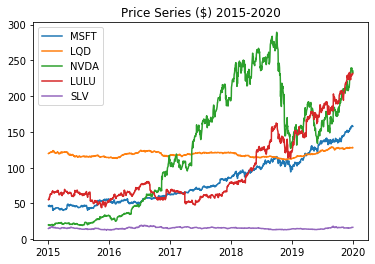

In [6]:
plt.plot(df.loc['MSFT']['prc'], label = 'MSFT')
plt.plot(df.loc['LQD']['prc'], label = 'LQD')
plt.plot(df.loc['NVDA']['prc'], label = 'NVDA')
plt.plot(df.loc['LULU']['prc'], label = 'LULU')
plt.plot(df.loc['SLV']['prc'], label = 'SLV')
plt.title('Price Series ($) 2015-2020')
plt.legend()

### Plotting returns series of each individual security 

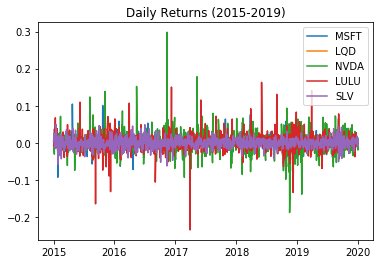

In [7]:
#Plotting daily stock returns from 2015-2019
plt.plot(df.loc['MSFT']['retx'], label = 'MSFT')
plt.plot(df.loc['LQD']['retx'], label = 'LQD')
plt.plot(df.loc['NVDA']['retx'], label = 'NVDA')
plt.plot(df.loc['LULU']['retx'], label = 'LULU')
plt.plot(df.loc['SLV']['retx'], label = 'SLV')
plt.title('Daily Returns (2015-2019)')
plt.legend()

Separating Price and Returns in their own dataframes

In [8]:
env = env.reset_index()
tickers = list(env['ticker'].unique())
env = env.set_index(['ticker','date'])

returns = pd.DataFrame()
prices = pd.DataFrame()
for ticker in tickers:
    returns["{}_retx".format(ticker)] = env.loc[ticker]['retx']
    prices["{}_prc".format(ticker)] = env.loc[ticker]['prc']

### Markowitz Efficient Frontier

Creating the Markowitz Efficient Frontier through simulation of 5000 random portfolio weight arrays 

In [9]:
np.random.seed(13)
ports = 5000
sec_weights = np.zeros((ports, returns.shape[1]))
returns_ports = np.zeros(ports)
vol_ports = np.zeros(ports)
sharpe_ports = np.zeros(ports)

for x in range(ports):
    # Weights
    weights = np.array(np.random.random(5))
    weights = weights/np.sum(weights)
    
    # Save weights
    sec_weights[x,:] = weights
    
    # Expected return
    returns_ports[x] = np.sum( (returns.mean() * weights * 252))
    
    # Expected volatility
    vol_ports[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_ports[x] = returns_ports[x]/vol_ports[x]
    
print('Max Sharpe Ratio=%f Max Sharpe portfolio - %f' %(sharpe_ports.max(),sharpe_ports.argmax()))

Max Sharpe Ratio=1.647453 Max Sharpe portfolio - 3436.000000


### Random Portfolio #3436 yields the Highest Sharpe Ratio of 1.647

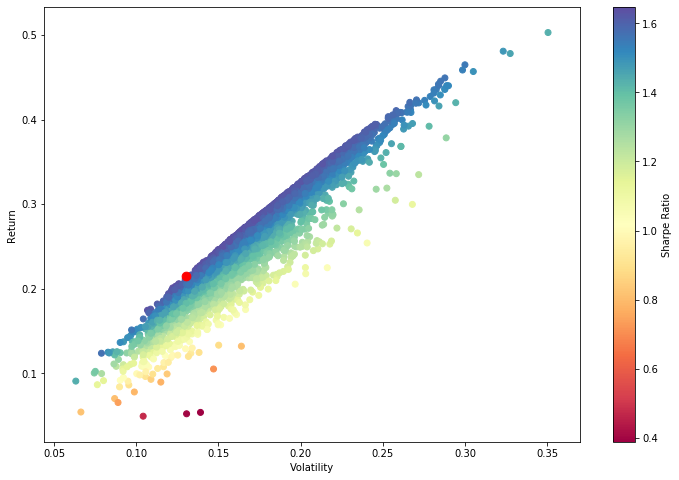

Sharpe Ratio for Efficient Portfoli 1.6475
Expected Return for Efficient Portfolio 0.2149
Standard Deviation for Efficient Portfolio 0.1304


In [10]:
max_sharpe_vol = vol_ports[sharpe_ports.argmax()]
max_sharpe_return = returns_ports[sharpe_ports.argmax()]
plt.figure(figsize=(12,8))
plt.scatter(vol_ports, returns_ports, c=sharpe_ports, cmap='Spectral')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_return,c='red', s=75)
plt.show()
print('Sharpe Ratio for Efficient Portfoli', round(sharpe_ports.max(),4))
print('Expected Return for Efficient Portfolio', round(max_sharpe_return,4))
print('Standard Deviation for Efficient Portfolio', round(max_sharpe_vol, 4))

###  Calculating Portfolio Mean and Portfolio Variance 

- Portfolio Mean: $ \hat{\mu}_p = E[x'R] = x'\mu $

- Portfolio Variance: $ \hat{\sigma}^2_p = x' \Sigma x $

- Portfolio Standard Deviation: $ \hat{\sigma}_p = \sqrt{\hat{\sigma}^2_p} $

Where x is nx1 position vector, $\Sigma$ is the nxn covariance matrix, and $ \mu $ is the nx1 mean return matrix 

### Finding the Efficient portfolio using Scipy optimize

In [11]:
def portfolio_returns(weights):
    weights = np.array(weights)
    port_returns = np.sum(returns.mean() * weights) * 252
    return port_returns

def portfolio_volatility(weights):
    weights = np.array(weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    return port_vol

def portfolio_sharpe(weights):
    weights = np.array(weights)
    port_sharpe = portfolio_returns(weights)/portfolio_volatility(weights)
    return port_sharpe

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

def neg_sharpe(weights):
    return portfolio_sharpe(weights)*-1
    

constraints = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
initial_weights = [0.2,0.2,0.2,0.2,0.2]

optimized_weights = minimize(neg_sharpe, initial_weights, method = 'SLSQP', bounds=bounds, constraints = constraints)
print(optimized_weights)

     fun: -1.648773837018386
     jac: array([ 0.00032558,  0.00011557,  0.00061087, -0.00175165,  0.00020914])
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.18446205, 0.42168929, 0.18501929, 0.1353772 , 0.07345218])


In [12]:
print('Return = %f Volatility = %f Sharpe = %f' %(portfolio_returns(optimized_weights.x), portfolio_volatility(optimized_weights.x), portfolio_sharpe(optimized_weights.x)))

Return = 0.215194 Volatility = 0.130518 Sharpe = 1.648774


In [13]:
w = optimized_weights.x
print(w)

[0.18446205 0.42168929 0.18501929 0.1353772  0.07345218]


### Risk Metrics

Value at Risk, Historical Value at Risk, and Expected Shortfall calculations

In [14]:
#Normal distribution VaR calculation
# Paramenters
# mu: mean returns
# sigma: volatility
# a: percentage level (eg 5% = 0.05)
# N: day period
# d: dollar value of portolio
def ndayvar(mu,sigma,a,N=1):
    z = norm.ppf(1-a)
    return -(mu - z*sigma)*np.sqrt(N)

#Expected Shortfall 
# Parameters 
# mu: mean returns
# sigma: volatility
# a: percentage level (eg 5% = 0.05)
# d: dollar value of portfolio 
def expected_shortfall(mu, sigma, a, d=1):
    return a**-1 * norm.pdf(norm.ppf(a))*sigma -mu

def hist_var(ret_df, ret_colname, a):
#ret_df: Returns Data Frame
#ret_colname: specific returns column name
#a: percentage level (eg 5% = 0.05)
    ret_sorted = (ret_df.copy()
                      .reset_index()
                      .sort_values(by =ret_colname, ascending = True))
    histX = (a)*len(ret_sorted)-1
    offset = math.modf(histX)
    histVaR = np.float(offset[0]) * ret_sorted[ret_colname].iloc[math.ceil(histX)] + (1-np.float(offset[0])) * ret_sorted[ret_colname].iloc[math.floor(histX)]
    return -histVaR


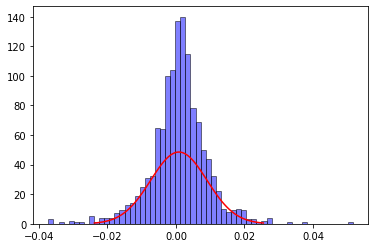

In [15]:
optimized_returns = returns*w
optimized_returns
optimized_returns['total_ret'] = optimized_returns.sum(axis=1)

#Calculating daily Mean and Volatility for the optimized portfolio
mu = portfolio_returns(optimized_weights.x)/252
sigma = portfolio_volatility(optimized_weights.x)/np.sqrt(252)

plt.hist(optimized_returns['total_ret'], color = 'blue', edgecolor = 'black', bins ='auto', alpha = 0.5)
norm_dist = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(norm_dist, stats.norm.pdf(norm_dist, mu, sigma), c = 'red')

In [16]:
VaR95 = ndayvar(mu,sigma,0.05)
ES95 = expected_shortfall(mu,sigma,0.05)
HVaR95 = hist_var(optimized_returns, 'total_ret', 0.05)

print('Portfolio 1 95% VaR is', round(VaR95, 5))
print('Portfolio 1 95%  Historical VaR is', round(HVaR95, 5))
print('Portfolio 1 95% ES is', round(ES95, 5))

Portfolio 1 95% VaR is 0.01267
Portfolio 1 95%  Historical VaR is 0.01257
Portfolio 1 95% ES is 0.01611


### Further Tail risk evaluation - Monte Carlo Simulation 

Covariance Matrix decomposition $ \Sigma = E' \Lambda^{{1}/{2}} \Lambda^{{1}/{2}} E $:

yields the transpose of Eigenvectors and the diagonal of the square root of Eigenvalues eg. yielding the Gaussian Copula, multiplied through by the diagonal matrix of the square root eigen values and the transpose of the Eigenvectors matrix.

If R is an nx1 random normal vector, and $ \Lambda^{{1}/{2}} $ is an nxn diagonal matrix containing the square roots of the Eigenvalues, and E is a matrix of Eigenvectors.

Then,  $ R \Lambda^{{1}/{2}} E' \sim N(0,\Sigma)$  yields an array that has the same covariance structure as our observed array

Note: All operations are conducted on the original unweighted return series, not the optimized return series

In [17]:
ret_cov = returns.cov()

#Eigenvector decomposition
eigenvals, eigenvecs = LA.eig(np.array(ret_cov))

In [18]:
eigenvals

array([8.54616365e-04, 4.57245558e-04, 1.47661830e-04, 1.65817138e-04,
       9.05685501e-06])

In [19]:
eigenvecs

array([[ 0.30084764,  0.02832702, -0.82346328, -0.48016367, -0.00627317],
       [-0.0026968 , -0.00427526,  0.03148511, -0.06896461,  0.99710933],
       [ 0.85605136,  0.43124005,  0.26132902,  0.11358268,  0.00376837],
       [ 0.41947767, -0.9015855 ,  0.08863755,  0.05764607, -0.00154295],
       [-0.02641924, -0.01883889,  0.49473977, -0.86513735, -0.07561115]])

The Transformation matrix is created by taking the square root of the eigenvalue diagonal matrix and multiplying it by the transpose eigenvector matrix 

In [20]:
transm = np.dot(np.sqrt(np.diag(eigenvals)),eigenvecs.T)
transm

array([[ 8.79492633e-03, -7.88377716e-05,  2.50256534e-02,
         1.22629356e-02, -7.72335319e-04],
       [ 6.05725100e-04, -9.14192256e-05,  9.22133569e-03,
        -1.92788741e-02, -4.02837620e-04],
       [-1.00064116e-02,  3.82595057e-04,  3.17557058e-03,
         1.07708967e-03,  6.01188885e-03],
       [-6.18306773e-03, -8.88057308e-04,  1.46260424e-03,
         7.42308524e-04, -1.11403740e-02],
       [-1.88788585e-05,  3.00076156e-03,  1.13407588e-05,
        -4.64345231e-06, -2.27548807e-04]])

The Transformation matrix allows us to created a synthetic time series by multiplying through any amount of random variables. The synthetic time series will exhibit the same correlations as our observed returns matrix, allows us to evaluate tail risk more closely.

We can simulate synthetic time series with a much larger degree of observation than our observed data set

In [21]:
# returns DataFrame only has 1258 observation for each security
returns.shape[0]

1258

In [22]:
# Optimized returns correlation matrix 
ret_corr = returns.corr()
ret_corr

,MSFT_retx,LQD_retx,NVDA_retx,LULU_retx,SLV_retx
MSFT_retx,1.000000,0.018481,0.467540,0.240200,0.009069
LQD_retx,0.018481,1.000000,-0.033769,0.007404,0.289915
NVDA_retx,0.467540,-0.033769,1.000000,0.217051,-0.059314
LULU_retx,0.240200,0.007404,0.217051,1.000000,-0.012044
SLV_retx,0.009069,0.289915,-0.059314,-0.012044,1.000000


In [23]:
#creating random array with 5000 observations for each security
np.random.seed(32)
randarray = np.random.rand(5000,5)
#multiplying through by transformation matrix 
rand_corr = np.dot(randarray, transm)
pd.DataFrame(rand_corr).corr()


,0,1,2,3,4
0,1.000000,0.017515,0.467992,0.238055,-0.003980
1,0.017515,1.000000,-0.032580,0.011082,0.304795
2,0.467992,-0.032580,1.000000,0.210192,-0.055817
3,0.238055,0.011082,0.210192,1.000000,0.006353
4,-0.003980,0.304795,-0.055817,0.006353,1.000000


When ran for 5000 observations the correlations between certain assets are still highly different from the observed correlations.

This is a result of sampling error, the more random variables we add into the set, the closer the results will be to our observed returns correlations

In [24]:
# using 10,000,000 observations for each security 
ra10mmrand = np.random.rand(10000000,5)
ra10mmtrans = np.dot(ra10mmrand, transm)
ra10mm = pd.DataFrame(ra10mmtrans)
ra10mm.corr()

,0,1,2,3,4
0,1.000000,0.018483,0.467479,0.239667,0.009131
1,0.018483,1.000000,-0.034014,0.007713,0.290386
2,0.467479,-0.034014,1.000000,0.216780,-0.059453
3,0.239667,0.007713,0.216780,1.000000,-0.012082
4,0.009131,0.290386,-0.059453,-0.012082,1.000000


Notice how the synthetic correlations converge towards the observed values, can use this time series to closely evaluate the behavior of the left tail

<a list of 350 Patch objects>

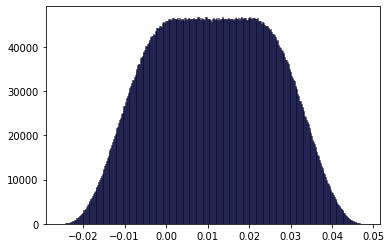

In [25]:
ra10mm_totalret = ra10mm.sum(axis=1)
plt.hist(ra10mm_totalret, color = 'blue', edgecolor = 'black', bins = 'auto' , alpha = 0.5)[2]
#norm_dist = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(norm_dist, stats.norm.pdf(norm_dist, mu, sigma), c = 'red')

With such a large # of observations we can see that the distribution appears to be normal, however we cannot see what is going on at left tail. However, due to the large # of observations we can sort by all values leading up to the 5th percentile and graph the distribution

<a list of 153 Patch objects>

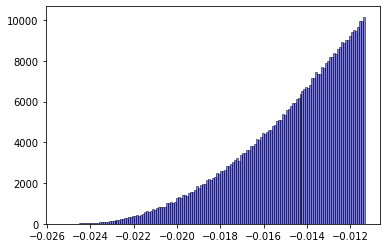

In [26]:
dfra10 = pd.DataFrame(ra10mm_totalret)
dfra10 = dfra10.sort_values(dfra10.columns[0], ascending = True)
dfra5pct = dfra10.iloc[0:500000,]
plt.hist(dfra5pct[0], color = 'blue', edgecolor = 'black', bins = 'auto' , alpha = 0.5)[2]

From this distribution we can see that the tail end does not drop off fast but rather eases of smoothly, indicating that the difference in the VaR and ES results is purely from the calculation method, with ES being the Integral of VaR, and not from the odd behavior in the left tail of the distribution.